In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [3]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)
plotprefix = "compare_elbo_rmse_trendfiltering"

/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering/trendfiltering.db


In [4]:
target = ["simulate", "simulate.n", "simulate.strue", "simulate.sfix", "simulate.dtrue", "fit"]
condition = [""]

In [5]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table

In [6]:
qp_df

,DSC,simulate,simulate.strue,simulate.sfix,simulate.output.file,simulate.n,simulate.dtrue,fit,fit.output.file
0,1,changepoint,0.1,4,changepoint/changepoint_1,1024,0,gradvi_compound_init,gradvi_compound_init/changepoint_1_genlasso_1_...
1,1,changepoint,0.1,8,changepoint/changepoint_2,1024,0,gradvi_compound_init,gradvi_compound_init/changepoint_2_genlasso_1_...
2,1,changepoint,0.1,16,changepoint/changepoint_3,1024,0,gradvi_compound_init,gradvi_compound_init/changepoint_3_genlasso_1_...
3,1,changepoint,0.1,4,changepoint/changepoint_4,1024,1,gradvi_compound_init,gradvi_compound_init/changepoint_4_genlasso_1_...
4,1,changepoint,0.1,8,changepoint/changepoint_5,1024,1,gradvi_compound_init,gradvi_compound_init/changepoint_5_genlasso_1_...
...,...,...,...,...,...,...,...,...,...
895,10,changepoint,0.1,8,changepoint/changepoint_86,1024,1,gradvi_compound,gradvi_compound/changepoint_86_gradvi_compound_1
896,10,changepoint,0.1,16,changepoint/changepoint_87,1024,1,gradvi_compound,gradvi_compound/changepoint_87_gradvi_compound_1
897,10,changepoint,0.1,4,changepoint/changepoint_88,1024,2,gradvi_compound,gradvi_compound/changepoint_88_gradvi_compound_1
898,10,changepoint,0.1,8,changepoint/changepoint_89,1024,2,gradvi_compound,gradvi_compound/changepoint_89_gradvi_compound_1


In [7]:
dscout

,DSC,simulate,simulate.n,simulate.strue,simulate.snr,simulate.sfix,simulate.dtrue,fit,fit.DSC_TIME,tfmse.err,tfmae.err
0,1,changepoint,1024,0.1,83.300790,4,0,gradvi_compound_init,47.456988,0.000171,NaN
1,1,changepoint,1024,0.1,354.640198,8,0,gradvi_compound_init,62.107192,0.000285,NaN
2,1,changepoint,1024,0.1,304.026315,16,0,gradvi_compound_init,96.070703,0.000600,NaN
3,1,changepoint,1024,0.1,0.032363,4,1,gradvi_compound_init,265.230095,0.000291,NaN
4,1,changepoint,1024,0.1,0.002397,8,1,gradvi_compound_init,168.372170,0.000308,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1795,10,changepoint,1024,0.1,0.013460,8,1,gradvi_compound,1364.548229,NaN,0.028603
1796,10,changepoint,1024,0.1,0.085084,16,1,gradvi_compound,1195.814735,NaN,0.060722
1797,10,changepoint,1024,0.1,0.000317,4,2,gradvi_compound,226.455167,NaN,0.020433
1798,10,changepoint,1024,0.1,0.001373,8,2,gradvi_compound,86.235466,NaN,0.014458


In [8]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        elbo_path = data['model']['elbo_path']
    else:
        elbo_path = data['model']['fit']['varobj']
    if elbo_path.shape[0] > 0:
        return elbo_path[-1]
    else:
        return np.nan
    
    
def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.dtrue", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['tfmse.err'].isnull()]['tfmse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.dtrue'].unique()
    resdict = {'simulate.sfix': [], 'simulate.dtrue': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.dtrue", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.dtrue'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    #print(pve, sfix, idsc, method)
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.dtrue'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

In [9]:
if refresh_pickle:
    elbodf = get_elbodf(qp_df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [10]:
if refresh_pickle:
    msedf = get_msedf(elbodf, dscout)
    msedf.to_pickle(msepkl)
else:
    msedf = pd.read_pickle(msepkl)

In [11]:
## Drop rows which did not converge
def filter_convergence_status(df, methods = [], remove_status = [2, 3, 4]):
    if len(methods) == 0:
        methods = [x[:-7] for x in list(df.columns) if x.endswith("_status")]
    for method in methods:
        for sidx in remove_status:
            df = df[df[f"{method}_status"] != sidx]
    return df
elbodf_filtered = filter_convergence_status(elbodf, remove_status = [2, 4])
msedf_filtered  = filter_convergence_status(msedf,  remove_status = [2, 4])

In [12]:
msedf_filtered

,simulate.sfix,simulate.dtrue,DSC,gradvi_compound_init,gradvi_compound_scaled,gradvi_compound_scaled_init,mr_ash,mr_ash_init,mr_ash_scaled,mr_ash_scaled_init,...,gradvi_compound_init_status,gradvi_compound_scaled_status,gradvi_compound_scaled_init_status,mr_ash_status,mr_ash_init_status,mr_ash_scaled_status,mr_ash_scaled_init_status,gradvi_direct_status,gradvi_direct_init_status,gradvi_compound_status
0,4,0,1,0.000171,0.001208,0.000171,0.016256,0.000164,0.002212,0.000623,...,1,1,1,1,1,1,1,1,1,1
1,4,0,2,0.000211,0.000149,0.000211,0.008508,0.000144,0.003463,0.000978,...,1,1,1,1,1,1,1,1,1,1
2,4,0,3,0.000083,0.001228,0.000083,0.014790,0.000058,0.003195,0.000473,...,1,1,1,1,1,1,1,1,1,1
3,4,0,4,0.000304,0.005991,0.000304,0.002014,0.000273,0.000965,0.000397,...,1,1,1,1,1,1,1,3,1,1
4,4,0,5,0.000063,0.000822,0.000063,0.003760,0.000048,0.003673,0.000427,...,1,1,1,1,1,1,1,1,1,1
5,4,0,6,0.000104,0.002550,0.000104,0.013784,0.000059,0.005429,0.000509,...,1,1,1,1,1,1,1,3,1,1
6,4,0,7,0.000099,0.007580,0.000099,0.018185,0.000018,0.013332,0.000638,...,1,1,1,1,1,1,1,3,1,1
7,4,0,8,0.000182,0.000219,0.000182,0.005683,0.000256,0.002316,0.000603,...,1,1,1,1,1,1,1,1,1,1
8,4,0,9,0.000276,0.000945,0.000276,0.001134,0.000187,0.000341,0.000466,...,1,1,1,1,1,1,1,1,1,1
9,4,0,10,0.000226,0.000584,0.000226,0.002567,0.000224,0.000693,0.000317,...,1,1,1,1,1,1,1,1,1,1


In [13]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
#mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

In [14]:
def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def rand_jitter(arr, d = 0.02):
    stdev = d * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def truncate_jitter(arr, ylim, d = 0.04):
    xnew  = arr.copy()
    if ylim is not None:
        ydev  = d * (ylim[1] - ylim[0])
        ilow  = np.where(xnew < ylim[0] + ydev)[0]
        ihigh = np.where(xnew > ylim[1] - ydev)[0]
        if len(ilow) > 0:
            xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
        if len(ihigh) > 0:
            xnew[ihigh] = ylim[1] - ydev
    return xnew

def outlier_index_normal(data, factor = 0.9):
    data_nona = data[~np.isnan(data)]
    q3, q1 = np.percentile(data_nona, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data_nona)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))[0]
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))[0]
    return outlieridx, keepidx

def get_outlier_index(data, factor = 10.0, keep_outliers = True):
    if keep_outliers:
        iremove = np.where(np.isnan(data))[0]
        ikeep   = np.where(~np.isnan(data))[0]
    else:
        iremove, ikeep = outlier_index_normal(data, factor = factor)   
    return iremove, ikeep
    

def match_index(idx1, idx2):
    return np.intersect1d(idx1, idx2, assume_unique = True)

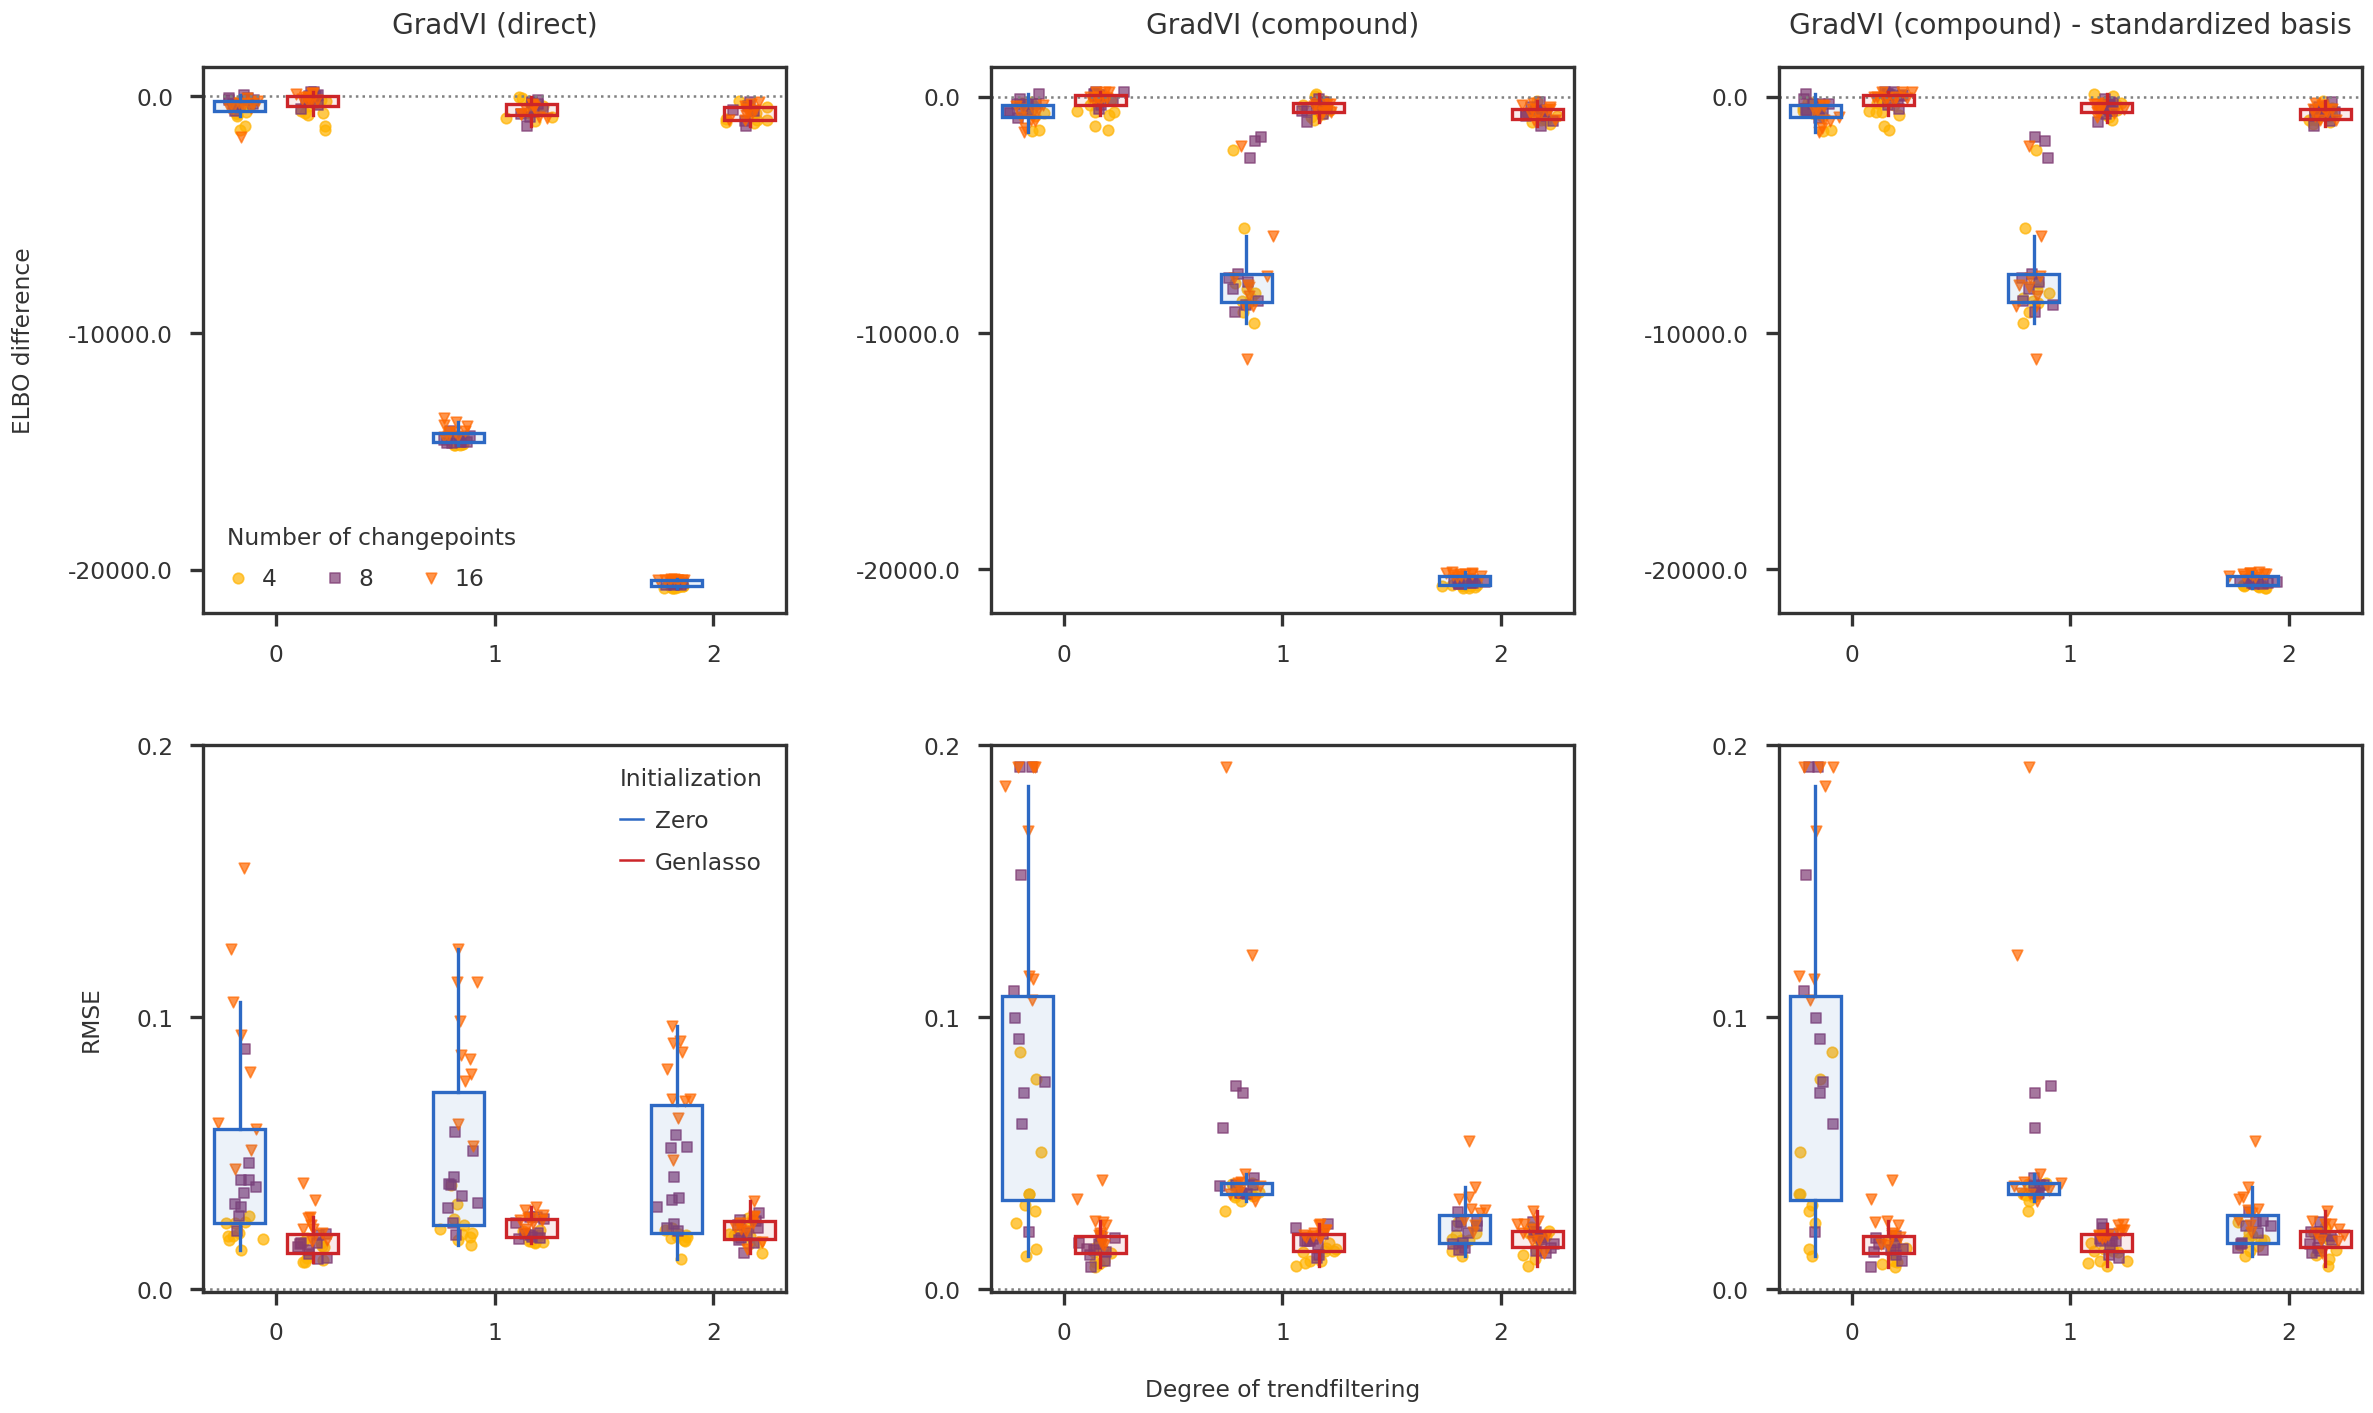

In [18]:
def plot_elbo_boxplot(ax, data_df, references, targets,
                      colors = None,
                      factr = 1, comparison_mode = 'absolute_diff',
                      keep_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, 
                      show_boxlegend = False, show_scatterlegend = False, box_labels = list(),
                      boxlegend_title = "Initialization",
                      ylim = None, debug = False):
    
    df = filter_convergence_status(data_df, methods = targets, remove_status = [])

    refs = [factr * df[reference].to_numpy() for reference in references]
    tgts = [factr * df[target].to_numpy() for target in targets]
    if comparison_mode == 'absolute_diff':
        diffs = [tgt - ref for ref, tgt in zip(refs, tgts)]
    elif comparison_mode == 'percentage_diff':
        diffs = [(tgt - ref) * 100 / np.abs(ref) for ref, tgt in zip(refs, tgts)]
    elif comparison_mode == 'proportional_diff':
        diffs = [(tgt - ref) / np.abs(ref) for ref, tgt in zip(refs, tgts)]
    elif comparison_mode == 'rmse':
        diffs = [np.sqrt(tgt) for tgt in tgts]

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.dtrue'].to_numpy())
    
    # Colors
    if colors is None:
        colors = mpl_stylesheet.banskt_colors()
    
    # The x-axis values and labels
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())
    
    # Box plot for each PVE
    if showboxplot:
        nbox = len(targets)
        for i, target in enumerate(targets):
            boxcolor = colors[i]
            boxface = f'#{boxcolor[1:]}16' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
            medianprops = dict(linewidth=0, color = boxcolor)
            whiskerprops = dict(linewidth=2, color = boxcolor)
            boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
            flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
            
            # plotting data
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 5.0, keep_outliers = keep_outliers)
            positions = np.array(range(len(xvals))) * (nbox + 1) + i
            ylist = [diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals]
            
            # print outliers
            if debug:
                print (f"Number of outliers removed : {iremove.shape[0]}")
                for j in iremove:
                    print(f"Index {j},\tPVE={pvevals[pveidx[j]]}, s={sfixvals[sfixidx[j]]}\t diff = {diff[j]:g}")
                print (f"Boxplot for {target}")
                print (ylist)
                print (positions)
            # ---------------
            
            ax.boxplot(ylist, positions = positions,
                       showcaps = False, showfliers = False,
                       widths = 0.7, patch_artist = True, notch = False,
                       flierprops = flierprops, boxprops = boxprops,
                       medianprops = medianprops, whiskerprops = whiskerprops)
            if show_boxlegend:
                ax.plot([], color = boxcolor, label = box_labels[i])
                
            
        label_positions = np.array(range(len(xvals))) * (nbox + 1) + (nbox - 1) / 2.0
        ax.set_xticks(label_positions)
        ax.set_xticklabels(xlabels)
        #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
        mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')
        
        if show_boxlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = boxlegend_title,
                             loc = 'upper right', bbox_to_anchor = (0.98, 0.98), ncol = 1)
            leg1._legend_box.align = "left"

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.kelly_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        
        nbox = len(targets)
        for i, target in enumerate(targets):
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 10.0, keep_outliers = keep_outliers)
            xpve = rand_jitter(pveidx * (nbox + 1) + i)
            
            diff_trunc = truncate_jitter(diff, ylim)
            for sidx, sfix in sfixvals.items():
                marker  = mmarkers[sidx]
                color   = mcolors[sidx]
                _idx    = np.where(sfixidx == sidx)[0]
                _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
                if i == 0:
                    ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                            alpha = 0.7, s = 40, linewidth = 1, label = f"{sfix}")
                else: # do not include label for second bar onwards
                    ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                            alpha = 0.7, s = 40, linewidth = 1)
        
        # legend for number of causal predictors
        if show_scatterlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = "Number of changepoints",
                             loc = 'lower left', bbox_to_anchor = (0.02, 0.02), ncol = 3)
            leg1._legend_box.align = "left"


fig = plt.figure(figsize = (20, 12))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)


elbo_ylim = None
plot_elbo_boxplot(ax1, elbodf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_direct", "gradvi_direct_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = True,
                  keep_outliers = True, ylim = elbo_ylim, debug = False)

plot_elbo_boxplot(ax2, elbodf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_compound_scaled", "gradvi_compound_scaled_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = False,
                  keep_outliers = True, ylim = elbo_ylim, debug = False)

plot_elbo_boxplot(ax3, elbodf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_compound", "gradvi_compound_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = False,
                  keep_outliers = True, ylim = elbo_ylim, debug = False)


mse_ylim = [-0.001, 0.2]
plot_elbo_boxplot(ax4, msedf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_direct", "gradvi_direct_init"],
                  comparison_mode = 'rmse', factr = 1,
                  show_boxlegend = True, box_labels = ['Zero', 'Genlasso'],
                  keep_outliers = False, ylim = mse_ylim, debug = False)

plot_elbo_boxplot(ax5, msedf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_compound_scaled", "gradvi_compound_scaled_init"],
                  comparison_mode = 'rmse', factr = 1,
                  show_boxlegend = False, box_labels = ['Zero', 'Genlasso'],
                  keep_outliers = False, ylim = mse_ylim, debug = False)

plot_elbo_boxplot(ax6, msedf,
                  ["mr_ash_init", "mr_ash_init"], ["gradvi_compound", "gradvi_compound_init"],
                  comparison_mode = 'rmse', factr = 1,
                  show_boxlegend = False, box_labels = ['Zero', 'Genlasso'],
                  keep_outliers = False, ylim = mse_ylim, debug = False)


ax1.set_ylabel(r"ELBO difference")
ax1.set_title("GradVI (direct)", pad = 20)
ax2.set_title("GradVI (compound)", pad = 20)
ax3.set_title("GradVI (compound) - standardized basis", pad = 20)
ax4.set_ylabel(r"RMSE")
ax5.set_xlabel("Degree of trendfiltering")

plt.tight_layout(w_pad = 3.0, h_pad = 3.0)
#utils.saveplot(fig, plotprefix)
plt.show()

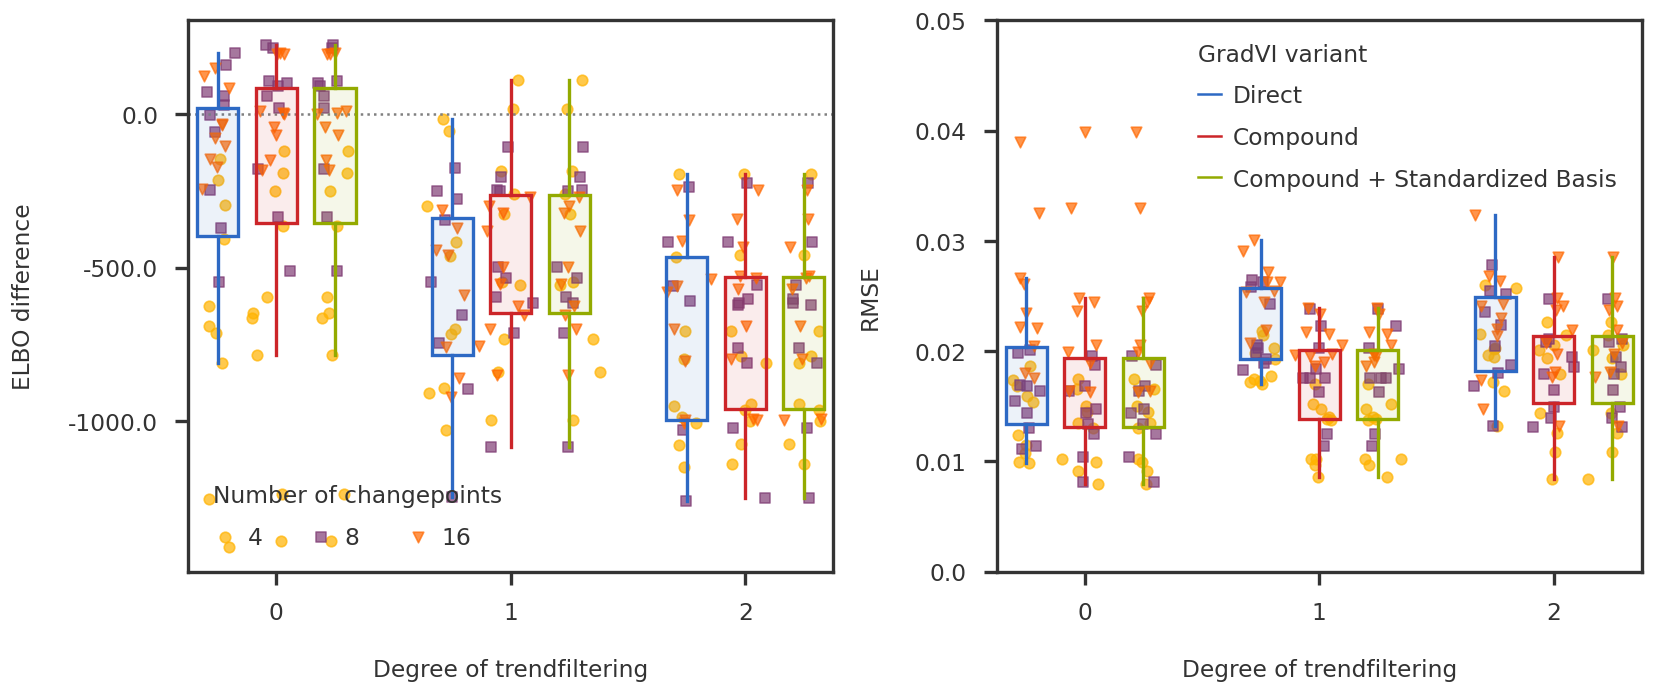

In [22]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_elbo_boxplot(ax1, elbodf,
                  ["mr_ash_init", "mr_ash_init", "mr_ash_init"], ["gradvi_direct_init", "gradvi_compound_init", 'gradvi_compound_scaled_init'],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = True,
                  keep_outliers = True, ylim = elbo_ylim, debug = False)

plot_elbo_boxplot(ax2, msedf,
                  ["mr_ash_init", "mr_ash_init", "mr_ash_init"], ["gradvi_direct_init", "gradvi_compound_init", 'gradvi_compound_scaled_init'],
                  comparison_mode = 'rmse', factr = 1, 
                  show_boxlegend = True, boxlegend_title = "GradVI variant", box_labels = ['Direct', 'Compound', 'Compound + Standardized Basis'],
                  keep_outliers = False, ylim = [0, 0.05], debug = False)

ax1.set_xlabel("Degree of trendfiltering")
ax2.set_xlabel("Degree of trendfiltering")

ax1.set_ylabel("ELBO difference")
ax2.set_ylabel("RMSE")

plt.tight_layout()
plt.show()